In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Info: Precompiling SatelliteDynamics [0e7c1a32-1b9f-5532-88a4-e668712d6a4c]
└ @ Base loading.jl:1186
┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386
┌ Info: Assigning UUID e935c413-f3b9-5f53-8ece-21fa9f65f3d6 to notebooks
└ @ Pkg.Types /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/Types.jl:841


 Resolving package versions...
  Updating `~/Stanford/repos/SatelliteTasking.jl/Project.toml`
  [c601a237] ↓ Interact v0.10.2 ⇒ v0.10.0
  [e935c413] + notebooks v0.0.0 [`notebooks`]
  Updating `~/Stanford/repos/SatelliteTasking.jl/Manifest.toml`
  [c601a237] ↓ Interact v0.10.2 ⇒ v0.10.0
  [e935c413] + notebooks v0.0.0 [`notebooks`]


┌ Info: Recompiling stale cache file /Users/deddy/.julia/compiled/v1.1/SatelliteTasking/HFrko.ji for SatelliteTasking [30f2e302-0ae1-11e9-1cda-0f4324764595]
└ @ Base loading.jl:1184


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/Stanford/repos/SatelliteTasking.jl/Project.toml`
 [no changes]
  Updating `~/Stanford/repos/SatelliteTasking.jl/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/Stanford/repos/SatelliteTasking.jl/Project.toml`
 [no changes]
  Updating `~/Stanford/repos/SatelliteTasking.jl/Manifest.toml`
 [no changes]


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 10

# Set Perturbation Values 
pos_error = 1000 # Position knowledge error [m]
vel_error = 1    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);

Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Simulating perturbed orbit 6
Simulating perturbed orbit 7
Simulating perturbed orbit 8
Simulating perturbed orbit 9
Simulating perturbed orbit 10
663.817503 seconds (14.97 G allocations: 369.778 GiB, 7.07% gc time)


In [3]:
# Compute True and perturbed collects

# Load test images
@time images = load_images("../data/landsat_test_150.json", collect_duration=5.0);
# @time images = load_images("../data/landsat_test_300.json", collect_duration=5.0);
# @time images = load_images("../data/landsat_test_600.json", collect_duration=5.0);
num_images = length(images)

# Compute true and perturbed opportunities
@time true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);

# 
@time collects = split_opportunities(true_opportunities, 10);

# Compute feasible collects
image_collects = group_image_collects(collects) # Group collects by image
num_feasible   = 0
for img in keys(image_collects)
    if length(image_collects[img]) > 0
        num_feasible += 1
    end
end
pct_feasible = num_feasible/num_images*100

println("$num_feasible out of $num_images images have collection opportunities.")

SystemError: SystemError: opening file "../data/landsat_test_600.json": No such file or directory

In [4]:
println(sdev_diff[1, :])
println(sdev_diff[2, :])
println(sdev_diff[3, :])
println(missing_opportunities)

UndefVarError: UndefVarError: sdev_diff not defined

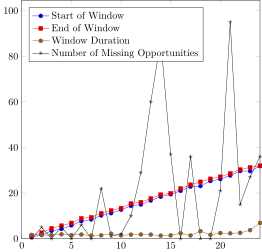

In [5]:
# Plot Differences in Opportunities
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_opportunities, legendentry="Number of Missing Opportunities")
], width="10cm", height="10cm", legendPos="north west", xmin=0, xmax=24, ymin=0)

In [6]:
# Graph planning
@time path, reward, image_list = sp_graph_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)
graph_path, graph_reward, graph_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

graph_feasible = sp_check_feasibility(graph_path, Function[constraint_agility_single_axis])
println("GRAPH Constraint Check: $(graph_feasible ? "PASS" : "FAIL")")

237.959317 seconds (966.00 M allocations: 44.421 GiB, 54.53% gc time)
Total planning reward: 546.0
Number of images collected: 546/600, 91.0
Number of feasible images collected: 546/552, 98.91304347826086
GRAPH Constraint Check: PASS


In [7]:
# MILP planning
@time path, reward, image_list = sp_milp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)
milp_path, milp_reward, milp_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

milp_feasible = sp_check_feasibility(milp_path, Function[constraint_agility_single_axis])
println("MILP Constraint Check: $(milp_feasible ? "PASS" : "FAIL")")

Academic license - for non-commercial use only
Optimize a model with 782976 rows, 18322 columns and 1583170 nonzeros
Variable types: 0 continuous, 18322 integer (18322 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 18322 integer (18322 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.18s

Solved with primal simplex

Root relaxation: objective 5.520000e+02, 795 iterations, 0.78 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                     552.0000000 18322.0000  3219%     -    2s
     0     0          -    0       552.00000  552.00000  0.00%     -    3s

Explored 0 nodes (2655 simplex iterations) in 3.33 seconds
Thread count was 12 (of 1

In [14]:
# MDP Planning

# Pre-compute collect probability
@time cp = compute_collect_probability(collects, perturbed_opportunities[1:10]);

 27.281694 seconds (582.40 k allocations: 27.781 MiB, 1.40% gc time)


In [15]:
# Test MDP Forward Search Solution
@time path, reward, image_list = mdp_forward_search(collects, Function[constraint_agility_single_axis], 
                                                    images, cp,
                                                    horizon=4000, gamma=0.7, search_depth=1);

mdp_path, mdp_reward, mdp_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

mdp_feasible = sp_check_feasibility(path, Function[constraint_agility_single_axis])
println("MDP Constraint Check: $(mdp_feasible ? "PASS" : "FAIL")")

Number of all images: 600, Collected: 489, Missed: 111
 76.753098 seconds (648.90 M allocations: 22.811 GiB, 12.43% gc time)
Total planning reward: 489.0
Number of images collected: 489/600, 81.5
Number of feasible images collected: 489/552, 88.58695652173914
MDP Constraint Check: PASS


In [16]:
# realized_reward, feasible_collects, infeasible_collects = sp_evaluate_plan(mdp_path, perturbed_opportunities[1])
# realized_reward, feasible_collects, infeasible_collects = sp_evaluate_plan(mdp_path, true_opportunities)
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(graph_path, perturbed_opportunities[11:end])

([524.0, 197.0, 231.0, 540.0, 544.0, 545.0, 543.0, 244.0, 534.0, 546.0  …  536.0, 192.0, 543.0, 183.0, 526.0, 291.0, 208.0, 294.0, 539.0, 546.0], 386.0888888888889, 151.44433059185306)

In [17]:
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(milp_path, perturbed_opportunities[11:end])

([533.0, 182.0, 211.0, 547.0, 551.0, 551.0, 549.0, 233.0, 543.0, 552.0  …  544.0, 173.0, 550.0, 164.0, 535.0, 290.0, 189.0, 293.0, 546.0, 552.0], 383.8333333333333, 161.98080410615452)

In [18]:
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(mdp_path, perturbed_opportunities[11:end])

([481.0, 221.0, 274.0, 488.0, 489.0, 489.0, 489.0, 293.0, 486.0, 489.0  …  489.0, 207.0, 489.0, 190.0, 483.0, 342.0, 232.0, 349.0, 489.0, 489.0], 381.97777777777776, 111.03273915177256)